In [1]:
import numpy as np
import time
import sys
import os
import tqdm

import torch
from torch import nn
import torch.nn.functional as F


from catr.configuration import Config
from catr.models.utils import NestedTensor, nested_tensor_from_tensor_list, get_rank
from catr.models.backbone import build_backbone
from catr.models.transformer_double_encoder import build_transformer_double_encoder
from catr.models.position_encoding import PositionEmbeddingSine
from catr.models.caption import MLP

import json

from dataset.dataset import ImageDoubleFeatureDataset
from torch.utils.data import DataLoader
from transformer_ethan_double_encoder import *
sys.path.append(os.path.join(os.path.dirname("__file__"), "catr"))
from engine_double_encoder import train_one_epoch_double_encoder, evaluate_double_encoder

In [2]:
# Load Word Embeddings
words = np.load("glove_embed.npy")
with open('word2ind.json') as json_file: 
    word2ind = json.load(json_file) 
with open('ind2word.json') as json_file: 
    ind2word = json.load(json_file) 
    
# Set up config file
config = Config()
config.device = 'cpu' # if running without GPU
config.feature_dim = 1024
config.pad_token_id = word2ind["<S>"]
config.hidden_dim = 300
config.nheads = 10
config.batch_size = 16
config.vocab_size = words.shape[0]
config.dir = '../mimic_features_double'
config.__dict__["pre_embed"] = torch.from_numpy(words)
config.__dict__["encoder_type"] = 2

In [3]:
model, criterion = main(config)
model = model.float()
device = torch.device(config.device)
model.to(device)

param_dicts = [
    {"params": [p for n, p in model.named_parameters(
    ) if "backbone" not in n and p.requires_grad]},
    {
        "params": [p for n, p in model.named_parameters() if "backbone" in n and p.requires_grad],
        "lr": config.lr_backbone,
    },
]

Initializing Device: cpu
Number of params: 46358432


In [4]:
optimizer = torch.optim.AdamW(
        param_dicts, lr=config.lr, weight_decay=config.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, config.lr_drop)

In [5]:
dataset_train = ImageDoubleFeatureDataset(config, mode='train')
dataset_val = ImageDoubleFeatureDataset(config, mode='val')

sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(
        sampler_train, config.batch_size, drop_last=True)

data_loader_train = DataLoader(
        dataset_train, batch_sampler=batch_sampler_train, num_workers=config.num_workers)
data_loader_val = DataLoader(dataset_val, config.batch_size,
                                 sampler=sampler_val, drop_last=False, num_workers=config.num_workers)
print(f"Train: {len(dataset_train)}")
print(f"Val: {len(dataset_val)}")

Train: 128
Val: 128


In [6]:
'''
if os.path.exists(config.checkpoint):
    print("Loading Checkpoint...")
    checkpoint = torch.load(config.checkpoint, map_location='cpu')
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    config.start_epoch = checkpoint['epoch'] + 1
'''
print("Start Training..")

Start Training..


In [7]:
train_loss_hist = []
val_loss_hist = []

for epoch in range(config.start_epoch, 20):
    print(f"Epoch: {epoch}")
    epoch_loss = train_one_epoch_double_encoder(
        model, criterion, data_loader_train, optimizer, device, epoch, config.clip_max_norm)
    train_loss_hist.append(epoch_loss)
    lr_scheduler.step()
    print(f"Training Loss: {epoch_loss}")
    '''
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'epoch': epoch,
    }, config.checkpoint)

    validation_loss = evaluate_double_encoder(model, criterion, data_loader_val, device)
    val_loss_hist.append(validation_loss)
    print(f"Validation Loss: {validation_loss}")
    '''
    print()

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 0


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 9.390686988830566

Epoch: 1


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 8.355441451072693

Epoch: 2


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 7.113301336765289

Epoch: 3


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 5.486894488334656

Epoch: 4


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 4.62146532535553

Epoch: 5


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 4.0830230712890625

Epoch: 6


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 3.497657001018524

Epoch: 7


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 2.9087489545345306

Epoch: 8


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 2.525684803724289

Epoch: 9


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 2.0941342413425446

Epoch: 10


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 1.8209930211305618

Epoch: 11


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 1.5118537843227386

Epoch: 12


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 1.1398151218891144

Epoch: 13


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 0.7704932317137718

Epoch: 14


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 0.4469180144369602

Epoch: 15


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 0.2097095102071762

Epoch: 16


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 0.07641982519999146

Epoch: 17


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 0.02248899615369737

Epoch: 18


  0%|          | 0/8 [00:00<?, ?it/s]

Training Loss: 0.007026082661468536

Epoch: 19


100%|██████████| 8/8 [01:16<00:00,  9.50s/it]

Training Loss: 0.003099758498137817



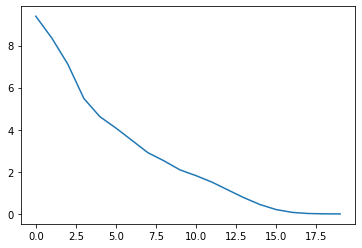

In [8]:
from matplotlib import pyplot as plt
plt.plot(train_loss_hist)
plt.show()

# Evaluation helper funcs

In [9]:
# Edward: note this makes a new caption as (<S>, 0, ..., 0) shouldn't we want as (<S>, <S>, ..., <S>)?
def create_caption_and_mask(start_token, max_length):
    caption_template = torch.zeros((1, max_length), dtype=torch.long)
    mask_template = torch.ones((1, max_length), dtype=torch.bool)

    caption_template[:, 0] = start_token
    mask_template[:, 0] = False

    return caption_template, mask_template

In [10]:
def make_report(captions):
    all_reports = []
    for report in captions:
        if (report == word2ind["</s>"]).any():
            end_index = (report == word2ind["</s>"]).nonzero()[0][0]
            report = report[:end_index+1]
        one_report = list(map(lambda x: ind2word[str(x)], report))
        all_reports.append(one_report)
    return all_reports

def reports_to_sentence(reports):
    return [' '.join(r) for r in make_report(reports)]

In [11]:
def evaluate(images):
    all_captions = []
    model.eval()
    for i in range(len(images[0])):
        image1 = images[0][i:i+1]
        image2 = images[1][i:i+1]
        caption, cap_mask = create_caption_and_mask(
            config.pad_token_id, config.max_position_embeddings)
        for i in range(config.max_position_embeddings - 1):
            predictions = model(image1, image2, caption, cap_mask)
            predictions = predictions[:, i, :]
            predicted_id = torch.argmax(predictions, axis=-1)


            caption[:, i+1] = predicted_id[0]
            cap_mask[:, i+1] = False
            
            if predicted_id[0] == word2ind["</s>"]:
                break

        all_captions.append(caption.numpy())
#     return make_report(all_captions)
    return all_captions

In [12]:
image, note, note_mask = next(iter(data_loader_train))

In [ ]:
report = evaluate(image)

In [ ]:
report_np = np.asarray(report).squeeze(1)
reports_to_sentence(report_np)

In [23]:
reports_to_sentence(np.asarray(note))

['<S> There is no focal consolidation , pleural effusion or pneumothorax . <s> Bilateral nodular opacities that most likely represent nipple shadows . <s> The cardiomediastinal silhouette is normal . <s> Clips project over the left lung , potentially within the breast . <s> The imaged upper abdomen is unremarkable . <s> Chronic deformity of the posterior left sixth and seventh ribs are noted . <s> </s>',
 '<S> There is no focal consolidation , pleural effusion or pneumothorax . <s> Bilateral nodular opacities that most likely represent nipple shadows . <s> The cardiomediastinal silhouette is normal . <s> Clips project over the left lung , potentially within the breast . <s> The imaged upper abdomen is unremarkable . <s> Chronic deformity of the posterior left sixth and seventh ribs are noted . <s> </s>',
 '<S> There is no focal consolidation , pleural effusion or pneumothorax . <s> Bilateral nodular opacities that most likely represent nipple shadows . <s> The cardiomediastinal silhoue